In [38]:
import pandas as pd
import numpy as np

%matplotlib inline

### Boston Public Library and Boston City Hall Electricity Consumption

We will analyze the electrical consuption data from Boston Public Library sampled every 5 min and Boston City Hall sampled every 15 min over a two year period from 2016 to 2017.

The data is again separated by date stamp, but we will focus on analyzing BPL for simplicity.



#### Loading the data and setting the DateTimeIndex

In [39]:
dataBPL = pd.read_csv('https://data.boston.gov/dataset/652762e9-2556-47cd-8e80-798546992a57/resource/87c759ee-63b9-4aec-a00b-bba1672a20ef/download/copleylibraryelectricuse.csv', skipinitialspace=True,
                   low_memory=False)
dataCH = pd.read_csv('https://data.boston.gov/dataset/1b894599-21ff-478f-937d-653954977951/resource/f123e65d-dc0e-4c83-9348-ed46fec498c0/download/cityhallelectricuse.csv', skipinitialspace=True,
                   low_memory=False)

In [3]:
dataBPL['Date'] = pd.to_datetime(dataBPL['DateTime_Measured'])
dataBPL.set_index('Date', inplace=True)

dataBPL['Year'] = dataBPL.index.year
dataBPL['Month'] = dataBPL.index.month
dataBPL['Day']= dataBPL.index.day
dataBPL['Weekday']= dataBPL.index.weekday
dataBPL['Hour']= dataBPL.index.hour
dataBPL['Time'] = dataBPL.index.time

In [4]:
dataCH['Date'] = pd.to_datetime(dataCH['DateTime_Measured'])
dataCH.set_index('Date', inplace=True)

dataCH['Year'] = dataCH.index.year
dataCH['Month'] = dataCH.index.month
dataCH['Day']= dataCH.index.day
dataCH['Weekday']= dataCH.index.weekday
dataCH['Hour']= dataCH.index.hour
dataCH['Time'] = dataCH.index.time

#### Filter the dataframe to Store 1 sales and aggregate over departments to compute the total sales per store.

In [5]:
# Filter to store 1 sales and average over weeks
#store1_sales = data[data.Store == 1][['Weekly_Sales']].resample('W', 'sum')
#store1_sales.head()

#### Plot the rolling_mean for `Weekly_Sales`. What general trends do you observe?

/Users/ebola/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=3,center=False).mean()
  """Entry point for launching an IPython kernel.


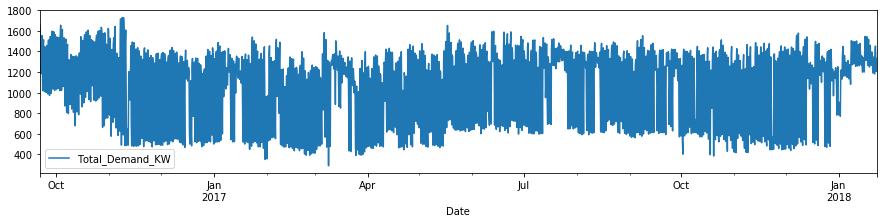

In [6]:
BPL_electric = pd.rolling_mean(dataBPL[['Total_Demand_KW']], 3).resample('6h').mean()
#BPL_electric = pd.rolling_mean(dataBPL[['Total_Demand_KW']], 3).resample('15min').mean()
#CH_electric = pd.rolling_mean(dataCH[['Total_Demand_KW']], 3).resample('D').mean()
BPL_electric.plot(figsize=(15,3))
#CH_electric.plot(figsize=(15,3),color='g')
#dataBPL[['Total_Demand_KW']].resample('H').rolling(window=3,center=False).mean().plot()
#dataCH[['Total_Demand_KW']].resample('H').rolling(window=3,center=False).mean().plot()

#### Compute the 1, 24, 168 autocorrelations for Boston Public Library Hourly_KW and autocorrelation plot.

In [7]:
print('Autocorrelation 1: ', BPL_electric['Total_Demand_KW'].autocorr(1))
print('Autocorrelation 7: ', BPL_electric['Total_Demand_KW'].autocorr(4))
print('Autocorrelation 168: ', BPL_electric['Total_Demand_KW'].autocorr(28))

('Autocorrelation 1: ', 0.15826934805998616)
('Autocorrelation 7: ', 0.85543554152492496)
('Autocorrelation 168: ', 0.84194275968778487)


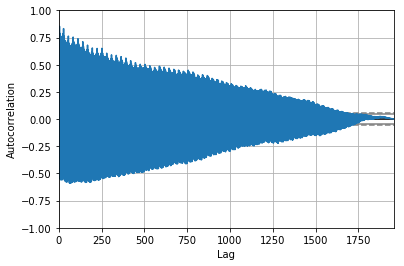

In [8]:
#from pandas.tools.plotting import autocorrelation_plot
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(BPL_electric['Total_Demand_KW'])
#autocorrelation_plot(CH_electric['Total_Demand_KW'])

In [9]:
BPL_electric.tail(5)

,Total_Demand_KW
Date,
2018-01-22 06:00:00,1389.171296
2018-01-22 12:00:00,1451.518519
2018-01-22 18:00:00,1332.356481
2018-01-23 00:00:00,1204.398148
2018-01-23 06:00:00,1322.804598


/Users/ebola/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


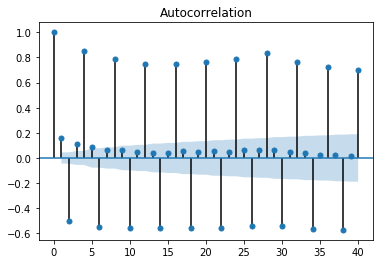

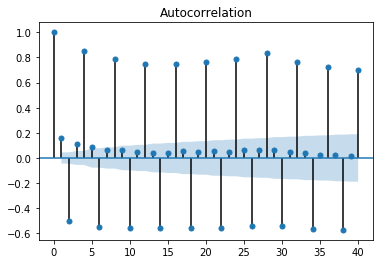

In [10]:
from statsmodels.graphics.tsaplots import plot_acf

#plot_acf(dataBPL['Total_Demand_KW'], lags=10000)
plot_acf(BPL_electric['Total_Demand_KW'], lags=40)

# The dataBPL dataset is sampled every 5 minutes and show correlation peaks every 
# 7 day (2016 data points) cycles and subpeaks every 24 hours. The correlation 
# factor is 0.8 at 168 hours (weekly) 

# Components 1 and 2 seem particularly useful for autoregression, perhaps up to 4
# In the plot above notice, spike at around 52 - implying a yearly pattern as well
# No random spikes, probably not much use for a moving average model

In [11]:
BPL_electric.tail()

,Total_Demand_KW
Date,
2018-01-22 06:00:00,1389.171296
2018-01-22 12:00:00,1451.518519
2018-01-22 18:00:00,1332.356481
2018-01-23 00:00:00,1204.398148
2018-01-23 06:00:00,1322.804598


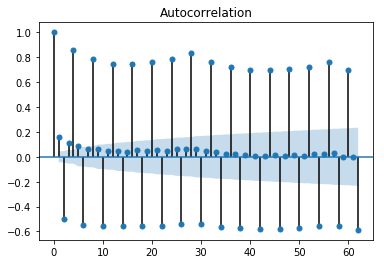

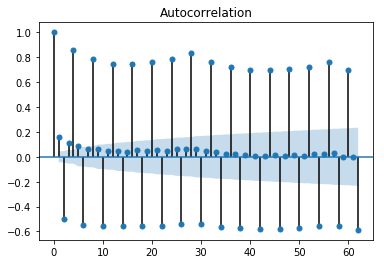

In [12]:

plot_acf(BPL_electric['Total_Demand_KW'], lags=62)

##### Split the energy consumption (5 min) data in a training and test set - using 75% of the data for training

In [13]:
#n = len(dataBPL.Total_Demand_KW)
n = len(BPL_electric.Total_Demand_KW)
#train = dataBPL.Total_Demand_KW[:int(.75*n)]
#test = dataBPL.Total_Demand_KW[int(.75*n):]
train = BPL_electric.Total_Demand_KW[:int(.75*n)]
test = BPL_electric.Total_Demand_KW[int(.75*n):]

In [14]:
test.head(5)

Date
2017-09-23 00:00:00    1257.212963
2017-09-23 06:00:00    1358.175926
2017-09-23 12:00:00    1396.504630
2017-09-23 18:00:00    1369.527778
2017-09-24 00:00:00     688.314815
Freq: 6H, Name: Total_Demand_KW, dtype: float64

In [15]:
test.tail(5)

Date
2018-01-22 06:00:00    1389.171296
2018-01-22 12:00:00    1451.518519
2018-01-22 18:00:00    1332.356481
2018-01-23 00:00:00    1204.398148
2018-01-23 06:00:00    1322.804598
Freq: 6H, Name: Total_Demand_KW, dtype: float64

#### Create an AR(1) model on the training data and compute the mean absolute error of the predictions.

In [16]:
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error

In [17]:
#model = sm.tsa.ARIMA(train, (1, 1, 0)).fit()
#print(model.params)

In [19]:
model = sm.tsa.ARIMA(train, (2, 1, 0)).fit()
#p: The number of lag observations included in the model, also called the lag order.
#d: The number of times that the raw observations are differenced, also called the degree of differencing.
#q: The size of the moving average window, also called the order of moving average.
predictions = model.predict(
    '2017-09-23 02:00:00',
    '2018-01-23 08:00:00',
    dynamic=True
)
#predictions = model.predict(
#    '2016-12-31 17:10:00',
#    '2017-10-31 08:10:00',
#    dynamic=True, 
#)
print("Mean absolute error: ", mean_absolute_error(test, predictions))
model.summary()

('Mean absolute error: ', 1090.0044398007233)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:      D.Total_Demand_KW   No. Observations:                 1466
Model:                 ARIMA(2, 1, 0)   Log Likelihood              -10309.725
Method:                       css-mle   S.D. of innovations            273.953
Date:                Tue, 23 Jan 2018   AIC                          20627.450
Time:                        11:11:10   BIC                          20648.611
Sample:                    09-21-2016   HQIC                         20635.343
                         - 09-22-2017                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -0.1853      3.631     -0.051      0.959      -7.302       6.931
ar.L1.D.Total_Demand_KW    -0.1858      0.016    -11.526      0.000      -0.217      -0.154
ar.L2.D.Total_Demand_KW    -0.7859      0.016    -48.896      0.000      -0.817      -0.754
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.1182           -1.1218j            1.1280           -0.2667
AR.2           -0.1182           +1.1218j            1.1280            0.2667
-----------------------------------------------------------------------------
"""

#### Plot the residuals - where are their significant errors.

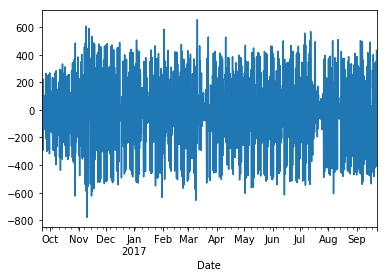

In [20]:
model.resid.plot()

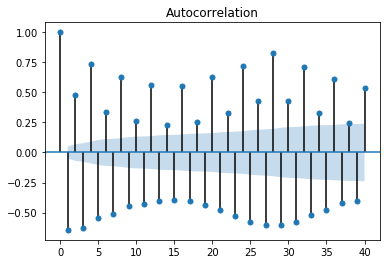

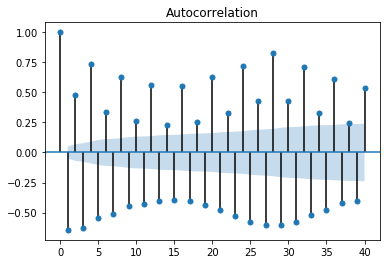

In [21]:
plot_acf(model.resid, lags=40)

#### Compute and AR(2) model and an ARMA(2, 2) model - does this improve your mean absolute error on the held out set.

In [22]:
model = sm.tsa.ARIMA(train, (2, 0, 0)).fit()

predictions = model.predict(
    '2017-09-23 02:00:00',
    '2018-01-23 08:00:00',
    dynamic=True, 
)

print("Mean absolute error: ", mean_absolute_error(test, predictions))
model.summary()

('Mean absolute error: ', 291.73143497574625)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:        Total_Demand_KW   No. Observations:                 1467
Model:                     ARMA(2, 0)   Log Likelihood              -10343.610
Method:                       css-mle   S.D. of innovations            279.123
Date:                Tue, 23 Jan 2018   AIC                          20695.219
Time:                        11:12:04   BIC                          20716.383
Sample:                    09-21-2016   HQIC                         20703.112
                         - 09-22-2017                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1080.4720      5.457    198.002      0.000    1069.777    1091.167
ar.L1.Total_Demand_KW     0.2284      0.022     10.585      0.000       0.186       0.271
ar.L2.Total_Demand_KW    -0.5645      0.022    -26.166      0.000      -0.607      -0.522
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.2023           -1.3156j            1.3310           -0.2257
AR.2            0.2023           +1.3156j            1.3310            0.2257
-----------------------------------------------------------------------------
"""

In [23]:
model = sm.tsa.ARIMA(train, (2, 0, 2)).fit()

predictions = model.predict(
    '2017-09-23 02:00:00',
    '2018-01-23 08:00:00',
    dynamic=True, 
)

print("Mean absolute error: ", mean_absolute_error(test, predictions))
model.summary()

('Mean absolute error: ', 215.46282599255304)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:        Total_Demand_KW   No. Observations:                 1467
Model:                     ARMA(2, 2)   Log Likelihood               -9822.262
Method:                       css-mle   S.D. of innovations            195.375
Date:                Tue, 23 Jan 2018   AIC                          19656.523
Time:                        11:12:34   BIC                          19688.269
Sample:                    09-21-2016   HQIC                         19668.363
                         - 09-22-2017                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1080.6427      5.142    210.178      0.000    1070.565    1090.720
ar.L1.Total_Demand_KW    -0.0017      0.003     -0.578      0.563      -0.007       0.004
ar.L2.Total_Demand_KW    -0.9942      0.003   -339.644      0.000      -1.000      -0.988
ma.L1.Total_Demand_KW     0.1143      0.024      4.746      0.000       0.067       0.162
ma.L2.Total_Demand_KW     0.8973      0.011     83.477      0.000       0.876       0.918
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.0008           -1.0029j            1.0029           -0.2501
AR.2           -0.0008           +1.0029j            1.0029            0.2501
MA.1           -0.0637           -1.0538j            1.0557           -0.2596
MA.2           -0.0637           +1.0538j            1.0557            0.2596
-----------------------------------------------------------------------------
"""

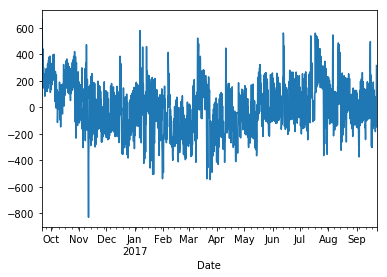

In [24]:
model.resid.plot()

#### Finally, compute an ARIMA model to improve your prediction error - iterate on the p, q, and parameters comparing the model's performance.

In [25]:
model = sm.tsa.ARIMA(train, (2, 1, 3)).fit()

predictions = model.predict(
    '2017-09-23 02:00:00',
    '2018-01-23 08:00:00',
    dynamic=False, 
    typ='levels'
)

print("Mean absolute error: ", mean_absolute_error(test, predictions))
model.summary()

('Mean absolute error: ', 198.58243462502753)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:      D.Total_Demand_KW   No. Observations:                 1466
Model:                 ARIMA(2, 1, 3)   Log Likelihood               -9523.667
Method:                       css-mle   S.D. of innovations            160.010
Date:                Tue, 23 Jan 2018   AIC                          19061.335
Time:                        11:13:01   BIC                          19098.367
Sample:                    09-21-2016   HQIC                         19075.146
                         - 09-22-2017                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -0.2138      1.068     -0.200      0.841      -2.307       1.879
ar.L1.D.Total_Demand_KW     0.0003      0.002      0.175      0.861      -0.003       0.003
ar.L2.D.Total_Demand_KW    -0.9979      0.001   -742.913      0.000      -1.001      -0.995
ma.L1.D.Total_Demand_KW    -0.7160      0.022    -32.111      0.000      -0.760      -0.672
ma.L2.D.Total_Demand_KW     0.8687      0.019     46.081      0.000       0.832       0.906
ma.L3.D.Total_Demand_KW    -0.6431      0.024    -26.386      0.000      -0.691      -0.595
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.0001           -1.0010j            1.0010           -0.2500
AR.2            0.0001           +1.0010j            1.0010            0.2500
MA.1           -0.0086           -1.0661j            1.0662           -0.2513
MA.2           -0.0086           +1.0661j            1.0662            0.2513
MA.3            1.3678           -0.0000j            1.3678           -0.0000
-----------------------------------------------------------------------------
"""

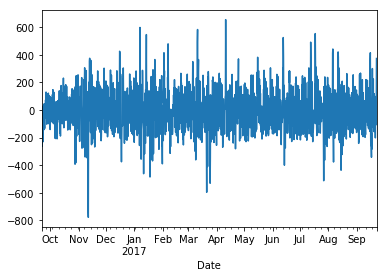

In [26]:
model.resid.plot()

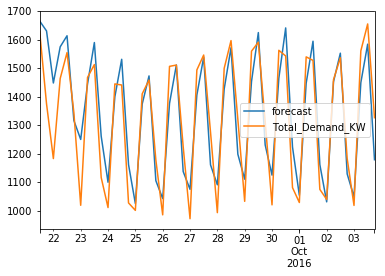

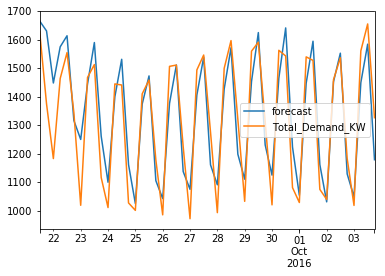

In [27]:
model.plot_predict(1, 50)

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt

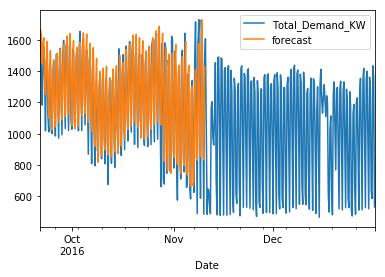

In [36]:
fig, ax = plt.subplots()
ax = BPL_electric['2016'].plot(ax=ax)

fig = model.plot_predict(1, 200, ax=ax, plot_insample=False)